In [1]:
#import des modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

<p style="color:blue;font-size:160%;font-weight:bold;padding-top:40px">PREMIERE PARTIE : REGRESSIONS</p>

**Machine Learning pour calculer la conso par région à un moment précis.
Calcul basé sur la température, l'heure, la population, le jour de la semaine, les jours feriés / vacances et les niveaux d'activités dans l'industrie et les services**

In [2]:
#récupération des données nécéssaires + données additionnelles
population = pd.read_csv('histo-population.csv', sep=';')
activeco = pd.read_csv('histo-va-millions-euros.csv', sep=';')
ferie = pd.read_csv('jours-feries.csv', sep=';')
vacances = pd.read_csv('vacances.csv', sep=';')
conso_ponctuelle = pd.read_csv('base_energie.csv')
conso_ponctuelle = conso_ponctuelle[['Région','Date','Heure','Consommation (MW)','Température (°C)']]
conso_ponctuelle['année'] = conso_ponctuelle['Date'].apply(lambda x : int(x[0:4]))
#récupération des 3 années où on a l'intégralité des données additionnelles
conso_ponctuelle = conso_ponctuelle[conso_ponctuelle['année'].isin([2016,2017,2018])]
conso_ponctuelle = pd.merge(conso_ponctuelle, population, how='left', left_on=['année', 'Région'], right_on=[
              'annee','région'])
conso_ponctuelle = conso_ponctuelle.drop(columns=['annee','région'])
conso_ponctuelle = pd.merge(conso_ponctuelle, activeco, how='left', left_on=['année', 'Région'], right_on=['année','région'])
conso_ponctuelle = conso_ponctuelle.drop(columns='région')
conso_ponctuelle = pd.merge(conso_ponctuelle, ferie, how='left', left_on='Date', right_on=
              'date')
conso_ponctuelle = conso_ponctuelle.drop(columns='date')
conso_ponctuelle = pd.merge(conso_ponctuelle, vacances, how='left', left_on=['Région','Date'],
              right_on=['nom_region','date_jour'])
conso_ponctuelle = conso_ponctuelle.drop(columns=['nom_region','date_jour'])
conso_ponctuelle['Date'] = pd.to_datetime(conso_ponctuelle['Date'])
conso_ponctuelle['jour'] = conso_ponctuelle["Date"].dt.weekday
conso_ponctuelle['jour'] = conso_ponctuelle['jour'].replace(to_replace=[0,1,2,3,4,5,6],
                                value=['lundi','mardi','mercredi','jeudi','vendredi','samedi','dimanche'])
conso_ponctuelle = conso_ponctuelle.drop(columns=['Région','Date','année'])
conso_ponctuelle['nom_jour_ferie'].fillna('non', inplace=True)
conso_ponctuelle = pd.get_dummies(conso_ponctuelle)
conso_ponctuelle = conso_ponctuelle.dropna(axis = 0, how = 'any')
conso_ponctuelle.head()

Consommation (MW)  Température (°C)  population  agriculture  industrie  \
0             5969.0          7.500000     6006870         2523      24205   
1             2446.0          4.900000     2577866         1343      12091   
2             5570.0          7.300000     5935603         6296      21259   
3             8114.0          5.600000     7916889         2375      41806   
4             5228.0          7.128571     5808435         3214      19687   

   service  Heure_00:00  Heure_00:30  Heure_01:00  Heure_01:30  Heure_02:00  \
0    24233            1            0            0            0            0   
1    10554            1            0            0            0            0   
2    26012            1            0            0            0            0   
3    40147            1            0            0            0            0   
4    24175            1            0            0            0            0   

   Heure_02:30  Heure_03:00  Heure_03:30  Heure_04:00  Heure_04:30  \
0            0            0            0            0            0   
1            0            0            0            0            0   
2            0            0            0            0            0   
3            0            0            0            0            0   
4            0            0            0            0            0   

   Heure_05:00  Heure_05:30  Heure_06:00  Heure_06:30  Heure_07:00  \
0            0            0            0            0            0   
1            0            0            0            0            0   
2            0            0            0            0            0   
3            0            0            0            0            0   
4            0            0            0            0            0   

   Heure_07:30  Heure_08:00  Heure_08:30  Heure_09:00  Heure_09:30  \
0            0            0            0            0            0   
1            0            0            0            0            0   
2            0            0            0            0            0   
3            0            0            0            0            0   
4            0            0            0            0            0   

   Heure_10:00  Heure_10:30  Heure_11:00  Heure_11:30  Heure_12:00  \
0            0            0            0            0            0   
1            0            0            0            0            0   
2            0            0            0            0            0   
3            0            0            0            0            0   
4            0            0            0            0            0   

   Heure_12:30  Heure_13:00  Heure_13:30  Heure_14:00  Heure_14:30  \
0            0            0            0            0            0   
1            0            0            0            0            0   
2            0            0            0            0            0   
3            0            0            0            0            0   
4            0            0            0            0            0   

   Heure_15:00  Heure_15:30  Heure_16:00  Heure_16:30  Heure_17:00  \
0            0            0            0            0            0   
1            0            0            0            0            0   
2            0            0            0            0            0   
3            0            0            0            0            0   
4            0            0            0            0            0   

   Heure_17:30  Heure_18:00  Heure_18:30  Heure_19:00  Heure_19:30  \
0            0            0            0            0            0   
1            0            0            0            0            0   
2            0            0            0            0            0   
3            0            0            0            0            0   
4            0            0            0            0            0   

   Heure_20:00  Heure_20:30  Heure_21:00  Heure_21:30  Heure_22:00  \
0            0            0            0  

In [3]:
cible = conso_ponctuelle['Consommation (MW)']
data = conso_ponctuelle.drop(columns = 'Consommation (MW)')
X_train, X_test, y_train, y_test = train_test_split(data, cible, test_size=0.2, random_state=789)

In [4]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [5]:
print('Coefficient de détermination du modèle :', lr.score(X_train, y_train))
print('Coefficient de détermination obtenu par Cv :', cross_val_score(lr,X_train,y_train).mean())
print('score sur l\'ensemble de test :', lr.score(X_test, y_test))

Coefficient de détermination du modèle : 0.8805884059775567
Coefficient de détermination obtenu par Cv : 0.8805417679480948
score sur l'ensemble de test : 0.8799314357598431


**Machine Learning pour évaluer la conso de façon journalière**


In [6]:
#récupération des données
conso_consolidee = pd.read_csv('base_energie.csv')
conso_consolidee = conso_consolidee[['Région','Date','Consommation (MW)','Température (°C)']]
conso_consolidee = conso_consolidee.groupby(['Région','Date'], as_index = False).agg({'Consommation (MW)':sum,'Température (°C)':'mean'})
conso_consolidee['année'] = conso_consolidee['Date'].apply(lambda x : int(x[0:4]))
#récupération des 3 années où on a l'intégralité des données additionnelles
conso_consolidee = conso_consolidee[conso_consolidee['année'].isin([2016,2017,2018])]
conso_consolidee = pd.merge(conso_consolidee, population, how='left', left_on=['année', 'Région'], right_on=[
              'annee','région'])
conso_consolidee = conso_consolidee.drop(columns=['annee','région'])
conso_consolidee = pd.merge(conso_consolidee, activeco, how='left', left_on=['année', 'Région'], right_on=['année','région'])
conso_consolidee = conso_consolidee.drop(columns='région')
conso_consolidee = pd.merge(conso_consolidee, ferie, how='left', left_on='Date', right_on=
              'date')
conso_consolidee = conso_consolidee.drop(columns='date')
conso_consolidee = pd.merge(conso_consolidee, vacances, how='left', left_on=['Région','Date'],
              right_on=['nom_region','date_jour'])
conso_consolidee = conso_consolidee.drop(columns=['nom_region','date_jour'])
conso_consolidee['Date'] = pd.to_datetime(conso_consolidee['Date'])
conso_consolidee['jour'] = conso_consolidee["Date"].dt.weekday
conso_consolidee['jour'] = conso_consolidee['jour'].replace(to_replace=[0,1,2,3,4,5,6],
                                value=['lundi','mardi','mercredi','jeudi','vendredi','samedi','dimanche'])
#création d'un dataframe paramètres qui stockera la région et la dateen vue de l'étude future des prédictions
parametres = conso_consolidee[['Région','Date']]
conso_consolidee = conso_consolidee.drop(columns=['Région','Date','année'])
conso_consolidee['nom_jour_ferie'].fillna('non', inplace=True)
conso_consolidee = pd.get_dummies(conso_consolidee)
conso_consolidee.head()

Consommation (MW)  Température (°C)  population  agriculture  industrie  \
0           363348.0          6.804167     7916889         2375      41806   
1           375285.0          8.504167     7916889         2375      41806   
2           383484.0          5.417708     7916889         2375      41806   
3           435960.0          7.287500     7916889         2375      41806   
4           447468.0          6.766667     7916889         2375      41806   

   service  nom_jour_ferie_11 novembre  nom_jour_ferie_14 juillet  \
0    40147                           0                          0   
1    40147                           0                          0   
2    40147                           0                          0   
3    40147                           0                          0   
4    40147                           0                          0   

   nom_jour_ferie_1er janvier  nom_jour_ferie_1er mai  nom_jour_ferie_8 mai  \
0                           1                       0                     0   
1                           0                       0                     0   
2                           0                       0                     0   
3                           0                       0                     0   
4                           0                       0                     0   

   nom_jour_ferie_Ascension  nom_jour_ferie_Assomption  \
0                         0                          0   
1                         0                          0   
2                         0                          0   
3                         0                          0   
4                         0                          0   

   nom_jour_ferie_Jour de Noël  nom_jour_ferie_Lundi de Pentecôte  \
0                            0                                  0   
1                            0                                  0   
2                            0                                  0   
3                            0                                  0   
4                            0                                  0   

   nom_jour_ferie_Lundi de Pâques  nom_jour_ferie_Toussaint  \
0                               0                         0   
1                               0                         0   
2                               0                         0   
3                               0                         0   
4                               0                         0   

   nom_jour_ferie_non  nomvacance_Vacances d'hiver  nomvacance_Vacances d'été  \
0                   0                            0                          0   
1                   1                            0                          0   
2                   1                            0                          0   
3                   1                            0                          0   
4                   1                            0                          0   

   nomvacance_Vacances de Noël  nomvacance_Vacances de la Toussaint  \
0                            1                                    0   
1                            1                                    0   
2                            1                                    0   
3                            0                                    0   
4                            0                                    0   

   nomvacance_Vacances de printemps  nomvacance_cours  jour_dimanche  \
0                                 0                 0              0   
1                                 0                 0              0   
2                                 0                 0              1   
3                                 0                 1              0   
4                                 0                 1              0   

   jour_jeudi  jour_lundi  jour_mardi  jour_mercredi  jour_samedi  \
0           0           0           0              0            0   
1           0   

In [7]:
cible = conso_consolidee['Consommation (MW)']
data = conso_consolidee.drop(columns = 'Consommation (MW)')
X_train, X_test, y_train, y_test = train_test_split(data, cible, test_size=0.2, random_state=789)
lr2 = LinearRegression()
lr2.fit(X_train, y_train)
print('Coefficient de détermination du modèle :', lr2.score(X_train, y_train))
print('Coefficient de détermination obtenu par Cv :', cross_val_score(lr2,X_train,y_train).mean())
print('score sur l\'ensemble de test :', lr2.score(X_test, y_test))

Coefficient de détermination du modèle : 0.9054588308399287
Coefficient de détermination obtenu par Cv : 0.9046543985879462
score sur l'ensemble de test : 0.9016680914906142


**Détermination par graphique des moments où le modèle est moins performant** (modèle journalier)

In [8]:
#création d'un dataframe consolidé contenant l'intégralité des infos
#prediction sur l'ensemble du df data
parametres['prédictions'] = lr2.predict(data)
df_conso = pd.concat([parametres, cible, data], axis = 1)
df_conso['écart prévision'] = round((df_conso['prédictions'] - df_conso['Consommation (MW)']) / df_conso['Consommation (MW)'] * 100,2)
df_conso['jour de l\'année'] = df_conso['Date'].apply(lambda x : x.dayofyear)
df_conso.head()

Région       Date    prédictions  Consommation (MW)  \
0  Auvergne-Rhône-Alpes 2016-01-01  379061.872390           363348.0   
1  Auvergne-Rhône-Alpes 2016-01-02  372153.366239           375285.0   
2  Auvergne-Rhône-Alpes 2016-01-03  381418.426953           383484.0   
3  Auvergne-Rhône-Alpes 2016-01-04  396503.446985           435960.0   
4  Auvergne-Rhône-Alpes 2016-01-05  403372.986428           447468.0   

   Température (°C)  population  agriculture  industrie  service  \
0          6.804167     7916889         2375      41806    40147   
1          8.504167     7916889         2375      41806    40147   
2          5.417708     7916889         2375      41806    40147   
3          7.287500     7916889         2375      41806    40147   
4          6.766667     7916889         2375      41806    40147   

   nom_jour_ferie_11 novembre  nom_jour_ferie_14 juillet  \
0                           0                          0   
1                           0                          0   
2                           0                          0   
3                           0                          0   
4                           0                          0   

   nom_jour_ferie_1er janvier  nom_jour_ferie_1er mai  nom_jour_ferie_8 mai  \
0                           1                       0                     0   
1                           0                       0                     0   
2                           0                       0                     0   
3                           0                       0                     0   
4                           0                       0                     0   

   nom_jour_ferie_Ascension  nom_jour_ferie_Assomption  \
0                         0                          0   
1                         0                          0   
2                         0                          0   
3                         0                          0   
4                         0                          0   

   nom_jour_ferie_Jour de Noël  nom_jour_ferie_Lundi de Pentecôte  \
0                            0                                  0   
1                            0                                  0   
2                            0                                  0   
3                            0                                  0   
4                            0                                  0   

   nom_jour_ferie_Lundi de Pâques  nom_jour_ferie_Toussaint  \
0                               0                         0   
1                               0                         0   
2                               0                         0   
3                               0                         0   
4                               0                         0   

   nom_jour_ferie_non  nomvacance_Vacances d'hiver  nomvacance_Vacances d'été  \
0                   0                            0                          0   
1                   1                            0                          0   
2                   1                            0                          0   
3                   1                            0                          0   
4                   1                            0                          0   

   nomvacance_Vacances de Noël  nomvacance_Vacances de la Toussaint  \
0                            1                                    0   
1                            1                                    0   
2                            1                                    0   
3                            0                                    0   
4                            0                                    0   

   nomvacance_Vacances de printemps  nomvacance_cours  jour_dimanche  \
0                                 0                 0              0   
1                                 0                 0              0   
2                                 0                 0             

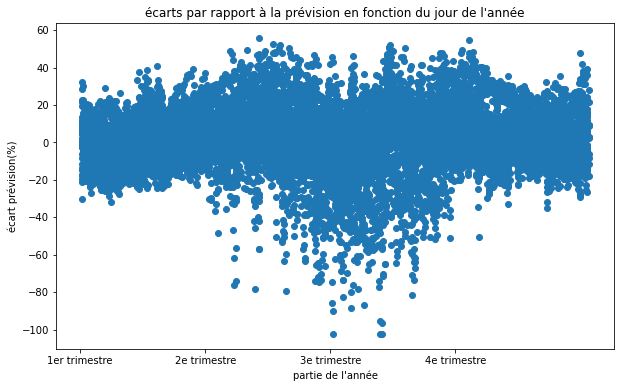

In [9]:
graph1 = df_conso[['jour de l\'année','écart prévision']]
plt.figure(figsize=(10,6))
plt.scatter(graph1['jour de l\'année'], graph1['écart prévision'])
plt.xlabel('partie de l\'année')
plt.xticks([0,90,180,270],['1er trimestre', '2e trimestre','3e trimestre','4e trimestre'])
plt.ylabel('écart prévision(%)')
plt.title('écarts par rapport à la prévision en fonction du jour de l\'année');

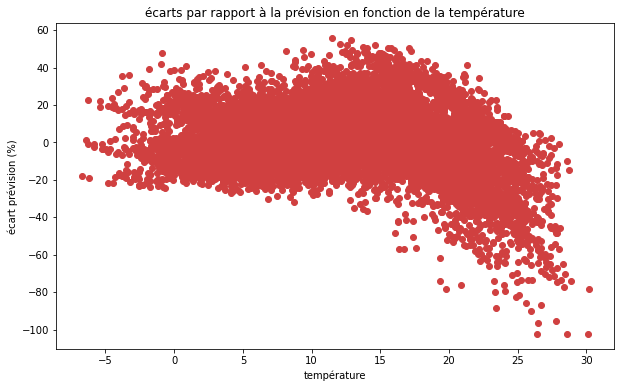

In [10]:
graph2 = df_conso[['Température (°C)','écart prévision']]
plt.figure(figsize=(10,6))
plt.scatter(graph2['Température (°C)'], graph2['écart prévision'], color='#d04040')
plt.xlabel('température')
plt.ylabel('écart prévision (%)')
plt.title('écarts par rapport à la prévision en fonction de la température');

On voit clairement que dès que les températures dépassent 15 degrés, le modèle a tendance à sous évaluer la consommation.
Un axe d'mélioration du modèle serait de mieux gérer les données où la température est élevée.

**Test du modèle sur les années postérieures avec des prédictions simplistes(1) de variation du volume d'activité par région pour 2019, 2020 et 2021**

(1) : application uniforme du taux de croissance du PIB national pour chaque région et secteur d'activité

In [11]:
#récupération et préparation des données
base_test = pd.read_csv('base_energie.csv')
base_test = base_test[['Région','Date','Consommation (MW)','Température (°C)']]
base_test = base_test.groupby(['Région','Date'], as_index = False).agg({'Consommation (MW)':sum,'Température (°C)':'mean'})
base_test['année'] = base_test['Date'].apply(lambda x : int(x[0:4]))
#récupération des 3 années test
base_test = base_test[base_test['année'] >= 2019]
prev_activeco = pd.read_csv('prevision-activite.csv', sep='\t')
base_test = pd.merge(base_test, population, how='left', left_on=['année', 'Région'], right_on=[
              'annee','région'])
base_test = base_test.drop(columns=['annee','région'])
base_test = pd.merge(base_test, prev_activeco, how='left', left_on=['année', 'Région'], right_on=['année','région'])
base_test = base_test.drop(columns='région')
base_test = pd.merge(base_test, ferie, how='left', left_on='Date', right_on=
              'date')
base_test = base_test.drop(columns='date')
base_test = pd.merge(base_test, vacances, how='left', left_on=['Région','Date'],
              right_on=['nom_region','date_jour'])
base_test = base_test.drop(columns=['nom_region','date_jour'])
base_test['Date'] = pd.to_datetime(base_test['Date'])
base_test['jour'] = base_test["Date"].dt.weekday
base_test['jour'] = base_test['jour'].replace(to_replace=[0,1,2,3,4,5,6],
                                value=['lundi','mardi','mercredi','jeudi','vendredi','samedi','dimanche'])
synthese = base_test[['Région','Date','Consommation (MW)']]
base_test = base_test.drop(columns=['Région','Date','année','Consommation (MW)'])
base_test['nom_jour_ferie'].fillna('non', inplace=True)
base_test = pd.get_dummies(base_test)
base_test.head()

Température (°C)  population  agriculture  industrie  service  \
0          5.456250     8042936         2491      44953    43482   
1          4.302083     8042936         2491      44953    43482   
2          1.275000     8042936         2491      44953    43482   
3          0.370833     8042936         2491      44953    43482   
4          1.296875     8042936         2491      44953    43482   

   nom_jour_ferie_11 novembre  nom_jour_ferie_14 juillet  \
0                           0                          0   
1                           0                          0   
2                           0                          0   
3                           0                          0   
4                           0                          0   

   nom_jour_ferie_1er janvier  nom_jour_ferie_1er mai  nom_jour_ferie_8 mai  \
0                           1                       0                     0   
1                           0                       0                     0   
2                           0                       0                     0   
3                           0                       0                     0   
4                           0                       0                     0   

   nom_jour_ferie_Ascension  nom_jour_ferie_Assomption  \
0                         0                          0   
1                         0                          0   
2                         0                          0   
3                         0                          0   
4                         0                          0   

   nom_jour_ferie_Jour de Noël  nom_jour_ferie_Lundi de Pentecôte  \
0                            0                                  0   
1                            0                                  0   
2                            0                                  0   
3                            0                                  0   
4                            0                                  0   

   nom_jour_ferie_Lundi de Pâques  nom_jour_ferie_Toussaint  \
0                               0                         0   
1                               0                         0   
2                               0                         0   
3                               0                         0   
4                               0                         0   

   nom_jour_ferie_non  nomvacance_Vacances d'hiver  nomvacance_Vacances d'été  \
0                   0                            0                          0   
1                   1                            0                          0   
2                   1                            0                          0   
3                   1                            0                          0   
4                   1                            0                          0   

   nomvacance_Vacances de Noël  nomvacance_Vacances de la Toussaint  \
0                            1                                    0   
1                            1                                    0   
2                            1                                    0   
3                            1                                    0   
4                            1                                    0   

   nomvacance_Vacances de printemps  nomvacance_cours  jour_dimanche  \
0                                 0                 0              0   
1                                 0                 0              0   
2                                 0                 0              0   
3                                 0                 0              0   
4                                 0                 0              0   

   jour_jeudi  jour_lundi  jour_mardi  jour_mercredi  jour_samedi  \
0           0           0           1              0            0   
1           0           0           0              1            0   
2           1           0           0              0         

In [12]:
synthese['conso prédite'] = lr2.predict(base_test)
print('Coefficient de détermination sur la base test :', lr2.score(base_test, synthese['Consommation (MW)']))

Coefficient de détermination sur la base test : 0.865839833348679


<p style="color:blue;font-size:160%;font-weight:bold;padding-top:40px"> DEUXIEME PARTIE : SERIES TEMPORELLES</p>

In [13]:
base_energie = pd.read_csv('base_energie.csv', index_col='Date', parse_dates=True).squeeze('columns')
base_energie.head()

Code INSEE région                   Région  Heure  \
Date                                                            
2013-01-01                 27  Bourgogne-Franche-Comté  00:00   
2013-01-01                 76                Occitanie  00:00   
2013-01-01                 24      Centre-Val de Loire  00:00   
2013-01-01                 28                Normandie  00:00   
2013-01-01                 52         Pays de la Loire  00:00   

                         Date - Heure  Consommation (MW)  Thermique (MW)  \
Date                                                                       
2013-01-01  2013-01-01T00:00:00+01:00                NaN             NaN   
2013-01-01  2013-01-01T00:00:00+01:00                NaN             NaN   
2013-01-01  2013-01-01T00:00:00+01:00                NaN             NaN   
2013-01-01  2013-01-01T00:00:00+01:00                NaN             NaN   
2013-01-01  2013-01-01T00:00:00+01:00                NaN             NaN   

            Nucléaire (MW)  Eolien (MW)  Solaire (MW)  Hydraulique (MW)  \
Date                                                                      
2013-01-01             NaN          NaN           NaN               NaN   
2013-01-01             NaN          NaN           NaN               NaN   
2013-01-01             NaN          NaN           NaN               NaN   
2013-01-01             NaN          NaN           NaN               NaN   
2013-01-01             NaN          NaN           NaN               NaN   

            Pompage (MW)  Bioénergies (MW)  Ech. physiques (MW)  \
Date                                                              
2013-01-01           NaN               NaN                  NaN   
2013-01-01           NaN               NaN                  NaN   
2013-01-01           NaN               NaN                  NaN   
2013-01-01           NaN               NaN                  NaN   
2013-01-01           NaN               NaN                  NaN   

            TCO Thermique (%)  TCH Thermique (%)  TCO Nucléaire (%)  \
Date                                                                  
2013-01-01                NaN                NaN                NaN   
2013-01-01                NaN                NaN                NaN   
2013-01-01                NaN                NaN                NaN   
2013-01-01                NaN                NaN                NaN   
2013-01-01                NaN                NaN                NaN   

            TCH Nucléaire (%)  TCO Eolien (%)  TCH Eolien (%)  \
Date                                                            
2013-01-01                NaN             NaN             NaN   
2013-01-01                NaN             NaN             NaN   
2013-01-01                NaN             NaN             NaN   
2013-01-01                NaN             NaN             NaN   
2013-01-01                NaN             NaN             NaN   

            TCO Solaire (%)  TCH Solaire (%)  TCO Hydraulique (%)  \
Date                                                                
2013-01-01              NaN              NaN                  NaN   
2013-01-01              NaN              NaN                  NaN   
2013-01-01              NaN              NaN                  NaN   
2013-01-01              NaN              NaN                  NaN   
2013-01-01              NaN              NaN                  NaN   

            TCH Hydraulique (%)  TCO Bioénergies (%)  TCH Bioénergies (%)  \
Date                                                                        
2013-01-01                  NaN                  NaN                  NaN   
2013-01-01                  NaN                  NaN                  NaN   
2013-01-01                  NaN                  NaN                  NaN   
2013-01-01                  NaN                  NaN                  NaN   
2013-01-01                  NaN                  NaN                  NaN   

            Température (°C)  
Date              

In [14]:
Conso_energie = base_energie.loc['2013':'2021','Consommation (MW)'].resample('M').sum()
Conso_energie.head(96)

Date
2013-01-31    106515355.0
2013-02-28     98659091.0
2013-03-31     98492373.0
2013-04-30     80269032.0
2013-05-31     73323639.0
                 ...     
2020-08-31     62378231.0
2020-09-30     64222994.0
2020-10-31     76205751.0
2020-11-30     79271553.0
2020-12-31     94786256.0
Freq: M, Name: Consommation (MW), Length: 96, dtype: float64

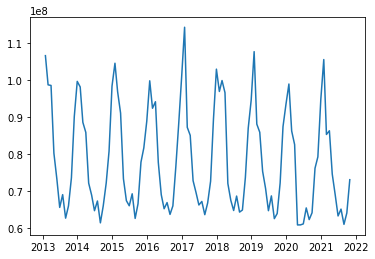

In [15]:
# Visualiser la série temporelle
plt.plot(Conso_energie);

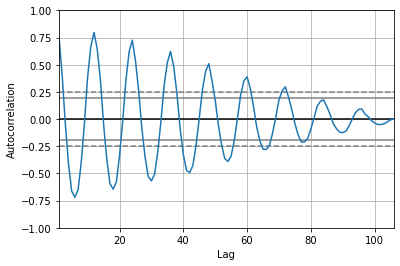

In [16]:
# La série semble stationnaire, mais pour le vérifier, on analyse son diagramme d'autocorrélation
pd.plotting.autocorrelation_plot(Conso_energie);
# On constate que la fonction d'autocorrélation décroit vers 0

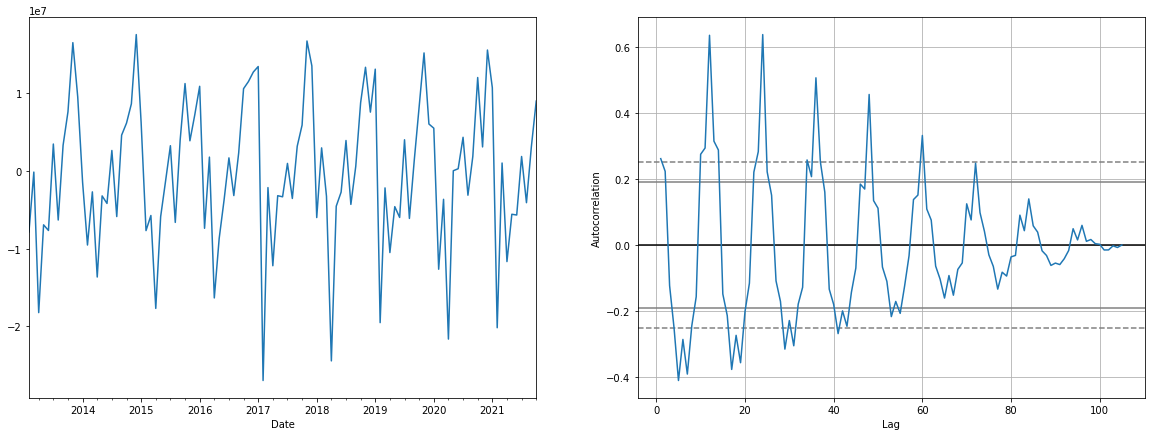

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7)) # Création de la figure et des axes

Conso_1 = Conso_energie.diff().dropna() # Différenciation de l'ordre 1
Conso_1.plot(ax = ax1) # Série temporelle différenciée

pd.plotting.autocorrelation_plot(Conso_1, ax= ax2);

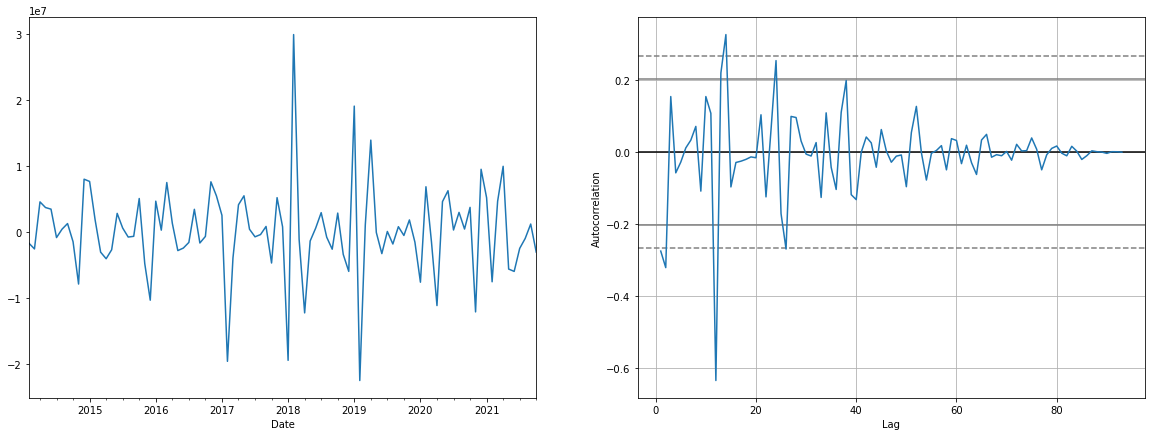

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7)) # Création de la figure et des axes

Conso_2 = Conso_1.diff(periods = 12).dropna()  # Différenciation d'ordre 12 car (12 mois)
Conso_2.plot(ax = ax1) # Notre série doublement différenciée

pd.plotting.autocorrelation_plot(Conso_2, ax = ax2); # Fonction d'autocorrelation de la série

In [19]:
# Pour s'assurer de la stationnarité de la série différenciée, on effectue un test ADF 
_, p_value, _, _, _, _  = sm.tsa.stattools.adfuller(Conso_2)
p_value 

1.2976515388190293e-05

C:\Users\julio\anaconda3\envs\data\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


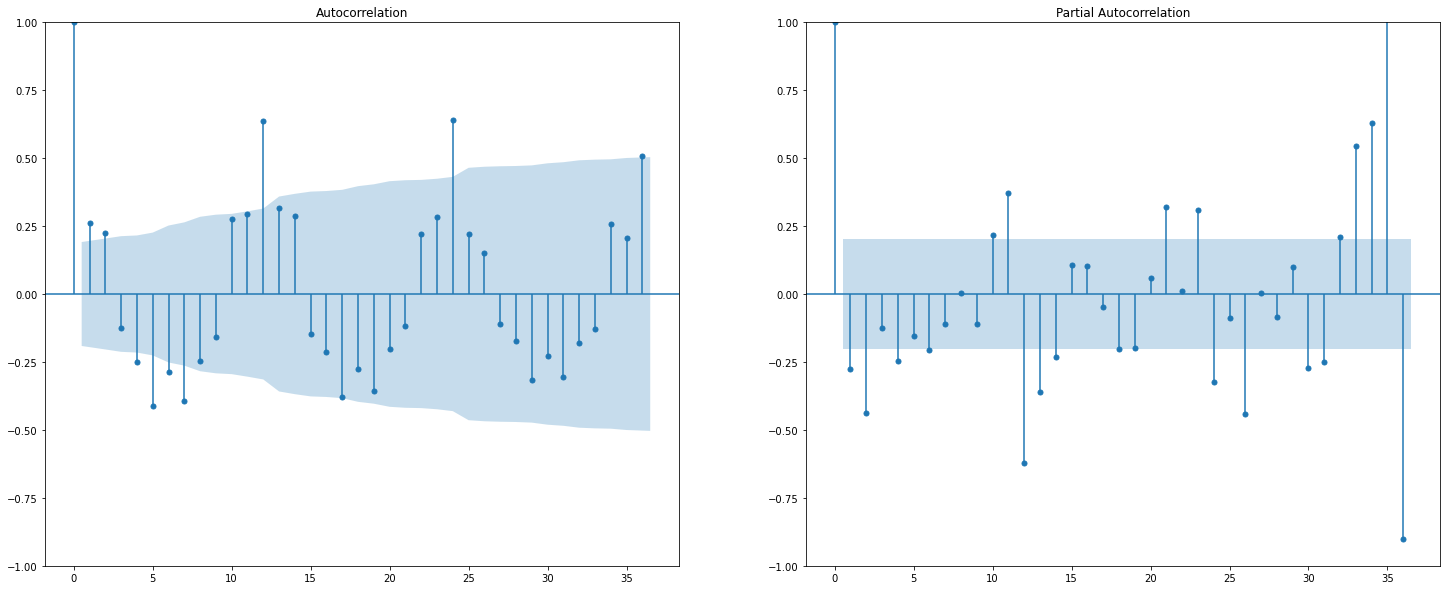

In [20]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(25,10))

plot_acf(Conso_1, lags=36, ax=ax1)
plot_pacf(Conso_2, lags=36, ax=ax2)
plt.show();

Le premier pic a une valeur de 1, celui-ci correspond à un décalage nul et sert d'échelle pour la suite de l'autocorrélogramme
Pour l'autocorrelation simple nous constatons une forte valleur au 12éme et 24éme pics, tandis que le 36 pic est plutot faible, a la limite de la zone de non significativité.
En ce qui concerne l'autocorrelation partielle, les 12 éme, 24éme et le 36éme pics sont significatifs.

In [21]:
# m = modèle(données, order=(p,d,q), seasonal_order = (P,D,Q,k))
# m_fitted = m.fit()
# Entrainement du modèle SARIMAX correspondant au modèle SARIMA(1.1.1)(0.1.1)12

model = sm.tsa.SARIMAX(Conso_energie, order=(1,1,1), seasonal_order=(0,1,1,12))
sarima = model.fit()
print(sarima.summary())

C:\Users\julio\anaconda3\envs\data\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


                                     SARIMAX Results                                      
Dep. Variable:                  Consommation (MW)   No. Observations:                  106
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood               -1582.119
Date:                            Thu, 07 Apr 2022   AIC                           3172.239
Time:                                    06:57:15   BIC                           3182.369
Sample:                                01-31-2013   HQIC                          3176.329
                                     - 10-31-2021                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3915      0.762      0.513      0.608      -1.103       1.886
ma.L1         -0.4919      0.772   

A la quatrième colonne P>z nous voyons que le paramètre AR d'ordre 1 a une p valeur bien supérieur à 5%.
Nous allons donc ajuster un modèle SARIMA(0.1.1)(0.1.1.1)12.

In [22]:
model = sm.tsa.SARIMAX(Conso_energie, order=(0,1,1), seasonal_order=(0,1,1,12))
sarima = model.fit()
print(sarima.summary())

C:\Users\julio\anaconda3\envs\data\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


                                     SARIMAX Results                                      
Dep. Variable:                  Consommation (MW)   No. Observations:                  106
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood               -1582.456
Date:                            Thu, 07 Apr 2022   AIC                           3170.912
Time:                                    06:57:15   BIC                           3178.510
Sample:                                01-31-2013   HQIC                          3173.979
                                     - 10-31-2021                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.1008      0.049     -2.076      0.038      -0.196      -0.006
ma.S.L12      -0.4396      0.049   

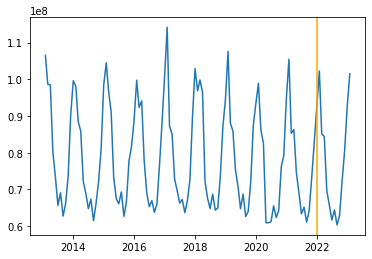

In [23]:
# A présent on constate que la p value est inférieur à 5%,
# Nous allons prédire les valeurs de la série sur les 12 mois suivant la dernieres valeur.

import datetime
pred = sarima.predict(108,120) # Prédiction
Conso_pred = pd.concat([Conso_energie, pred])

plt.plot(Conso_pred)
plt.axvline(x = datetime.date(2022,1,1), color="orange");

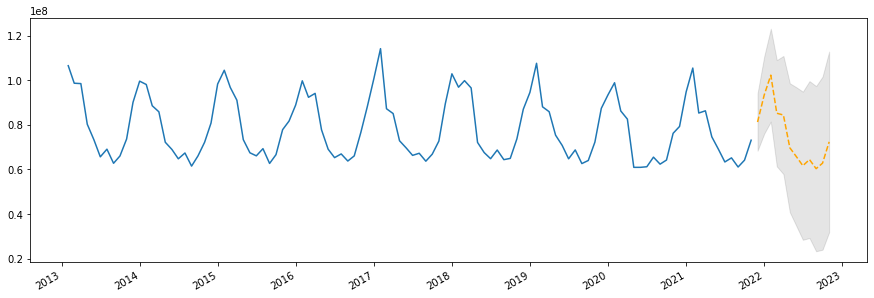

In [24]:
# Il est également possible de réprésenter une intervale de confiance via les méthodes get_forecast et get_prediction

prediction = sarima.get_forecast(steps =12).summary_frame()  #Prédiction avec intervalle de confiance

fig, ax = plt.subplots(figsize = (15,5))

plt.plot(Conso_energie)

prediction['mean'].plot(ax = ax, style = '--', color='orange') #Visualisation de la moyenne

ax.fill_between(prediction.index, prediction['mean_ci_lower'], prediction['mean_ci_upper'],
color='k', alpha=0.1); #Visualisation de l'intervalle de confiance